
# Convolutional Neural Network


Welcome to your fourth (last) assignment. You will train a convolutional neural network to classify images in this assignment. 

## Exercises:
1. $\color{violet}{\textbf{(10\%) Data Loading}}$
2. $\color{violet}{\textbf{(30\%) ConvNet Creation}}$
4. $\color{violet}{\textbf{(50\%) Training}}$
5. $\color{violet}{\textbf{(10\%) Evaluation}}$

## Instructions:
- Write your code only between the $\color{green}{\textbf{\small \#\#\# START CODE HERE \#\#\#}}$ and $\color{green}{\textbf{\small \#\#\# END CODE HERE \#\#\#}}$ commented lines. $\color{red}{\textbf{Do not modify code out of the designated area.}}$
- This assignment was originated from one of the [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

**You will learn:**

how to use PyTorch on
1. Loading built-in datasets and creating dataloaders 
2. Defining a Convolutional Neural Network
3. Defining a loss functions and an optimizer
4. Training a model.


## 1. Load Data
For this assignment, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


### $\color{violet}{\textbf{(10\%) Exercise 1: Data Loading}}$
1. Use `torchvision.datasets` to load CIFAR10 dataset into `train_set` and `test_set`.
2. Use `torch.utils.data.DataLoader` to create dataloaders for training data: `dataloader_train` and test data: `dataloader_test`.
3. Remeber to apply transforms on `train_set` and `test_set`

Number of training samples: 9469
Number of validation samples: 3925
Features shape: torch.Size([3, 160, 120])
Categories: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


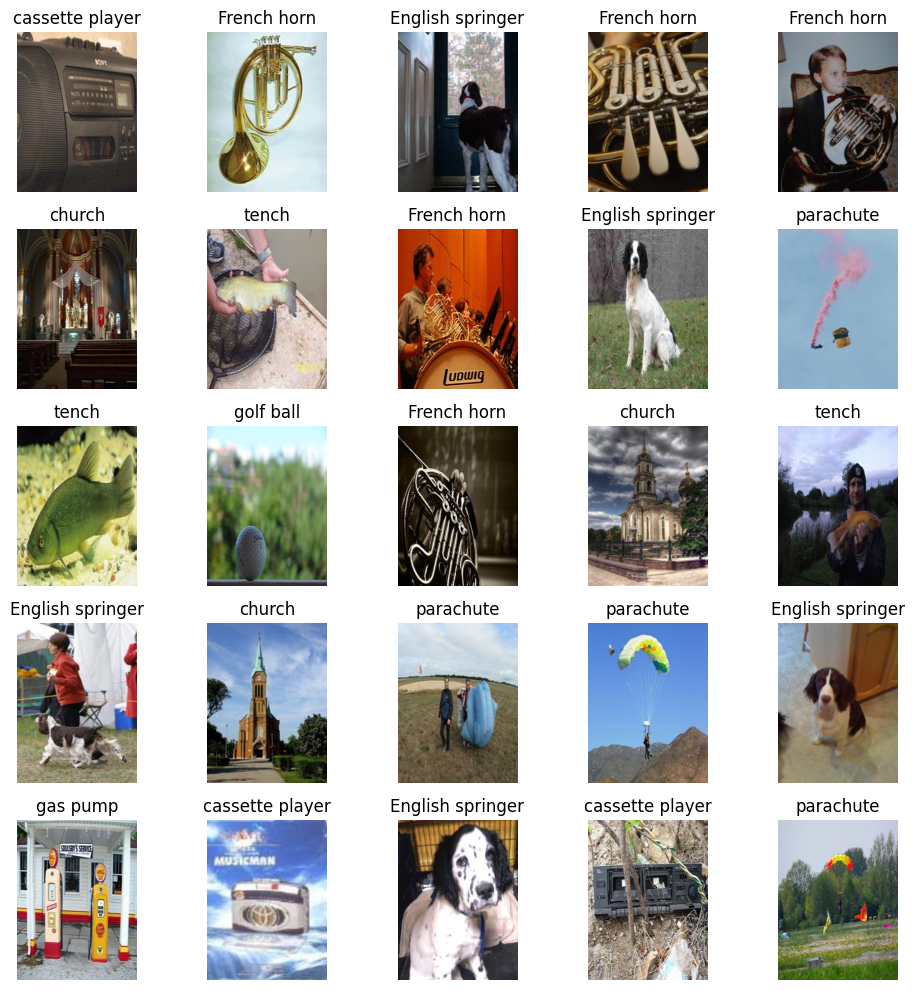

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import Compose, ToImage, RGB, Resize, ToDtype
import numpy as np
import matplotlib.pyplot as plt

# Construct transform pipeline for input features
transform_pipeline = Compose([
    ToImage(),
    RGB(),
    Resize((160, 120)),
    ToDtype(torch.float32, scale=True),
])

# Download datasets
dataset_train = datasets.Imagenette(
    root="data",
    split="train",
    size="160px",
    download=True,
    transform=transform_pipeline,
)

dataset_val = datasets.Imagenette(
   root="data",
    split="val",
    size="160px",
    download=True,
    transform=transform_pipeline,
)

labels = [c[0] for c in dataset_train.classes]

print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_val)}")
print(f"Features shape: {dataset_train[0][0].shape}")
print(f"Categories: {labels}")

# Create dataloaders
batch_size = 64
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# dataloader_val = DataLoader(dataset_val, batch_size=100000, shuffle=True)


# Visualize data samples
sample_batch_train = next(iter(dataloader_train))
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    sample_img = sample_batch_train[0][i].permute(1, 2, 0).numpy()  # reconstruct image to (H, W, C)
    sample_cls = sample_batch_train[1][i].item()
    sample_lbl = labels[sample_cls]
    axs[i//5, i%5].imshow(sample_img)
    axs[i//5, i%5].set_title(sample_lbl)
    axs[i//5, i%5].axis("off")
plt.tight_layout()


In [38]:
samples = next(iter(dataloader_train))
print(samples[0].shape)
print(samples[1])

torch.Size([64, 3, 160, 120])
tensor([0, 0, 6, 4, 4, 1, 8, 7, 3, 8, 3, 8, 0, 2, 7, 9, 0, 0, 8, 0, 6, 8, 1, 5,
        3, 5, 9, 3, 4, 8, 9, 8, 7, 5, 9, 8, 3, 0, 8, 6, 9, 1, 4, 8, 9, 0, 3, 2,
        1, 0, 0, 9, 0, 4, 1, 0, 5, 6, 7, 3, 9, 7, 1, 0])


<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



## 2. Create a Convolutional Neural Network

### $\color{violet}{\textbf{(30\%) Exercise 2: ConvNet Creation}}$
1. Use four convolution kernels to transform images.
2. The 1st convolution kernel has size of (3, 3), and stride of (2, 2). It will output 32 channels of features tensors with shape (32, 15, 15).
3. The 2nd convolution kernel has size of (3, 3), and stride of (2, 2). It will output 64 channels of features tensors with shape (64, 7, 7).
4. The 3rd convolution kernel has size of (3, 3), and stride of (1, 1). It will output 128 channels of features tensors with shape (128, 5, 5).
5. The 4th convolution kernel has size of (2, 2), and stride of (1, 1). It will output 128 channels of features tensors with shape (128, 4, 4).


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        ### START CODE HERE ### (≈ 4 lines of code)
        self.conv1 = None
        self.conv2 = None
        self.conv3 = None
        self.conv4 = None
        ### END CODE HERE ### 
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # 64 channels * 4 horizontal features * 4 vertical features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (32 - 3) / 2 + 1 = 15.5
        x = F.relu(self.conv2(x))  # (15 - 3) / 2 + 1 = 7
        x = F.relu(self.conv3(x))  # (7 - 3) + 1 = 5
        x = F.relu(self.conv4(x))  # (5 - 2) + 1 = 4
        x = x.view(-1, 128 * 4 * 4) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
model = ConvNet().to(device)  # use GPU if available
print(model)

## 3. Train the Model

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

### $\color{violet}{\textbf{(50\%) Exercise 3: Training}}$
1. Define a loss function for classification.
2. Define an appropriate optimizer.
3. Set a good learning rate for the optimizer.
4. Set a good training epochs number.
5. Make predictions.
6. Compute loss.
7. Compute gradient with back-propagation
8. Update model parameters.


In [ ]:
import torch.optim as optim
model = ConvNet().to(device)  # Re-initialize model parameters
losses_train = []
losses_test = []

### START CODE HERE ### (≈ 4 lines of code)
# Hyper-parameter setting
loss_fn = None
learning_rate = None
optimizer = None
num_epochs = None
### END CODE HERE ###
# Training loops
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print(f"----\nEpoch: {epoch + 1}")
    model.train(True)
    acc_loss_train = 0.0  # accumulated loss in an epoch
    avg_loss_train = 0.0  # averaged loss in an epoch
    for i, batch_train in enumerate(dataloader_train):
        optimizer.zero_grad()
        features_train, labels_train = batch_train[0].to(device), batch_train[1].to(device)  # get a batch of data; data is a list of [images, labels]
        ### START CODE HERE ### (≈ 4 lines of code)
        preds_train = None
        loss_train = None
        None  # back-propagation
        None  # update params
        ### END CODE HERE ###
        # Statistics
        acc_loss_train += loss_train.item()
        if not i % 200:    # print loss every 200 batches
            print(f"[batch: {i + i}] training batch loss: {loss_train.item()}")
            # loss_train = 0.0
    avg_loss_train = acc_loss_train / (i + 1)
    losses_train.append(avg_loss_train)
    print(f"Averaged training loss: {avg_loss_train}")
    # Test
    model.eval()
    acc_loss_test = 0.
    avg_loss_test = 0.
    with torch.no_grad():
        for i, batch_test in enumerate(dataloader_test):
            features_test, labels_test = batch_test[0].to(device), batch_test[1].to(device)
            preds_test = model(features_test)
            loss_test = loss_fn(preds_test, labels_test)
            acc_loss_test += loss_test.item()
    avg_loss_test = acc_loss_test / (i + 1)
    losses_test.append(avg_loss_test)
    print(f"Averaged test loss: {avg_loss_test}\n")


print('Finished Training')
plt.plot(losses_train, '#818A8F', linewidth=1)
plt.plot(losses_test, '#4F2D7F', linewidth=2.5)
plt.legend(['train', 'test'])

## 5. Evaluate the Convolutional Neural Network Model

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(dataloader_test)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:8]))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print('GroundTruth: \n', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
print('Predicted: \n', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))

The results seem pretty good.

Let us look at how the ConvNet model performs on the entire test dataset.

### $\color{violet}{\textbf{(10\%) Exercise 4: Model Accuracy}}$
$\color{red}{\text{The overall test accuracy has to be greater than }\textbf{65\%}}$


In [ ]:
num_correct = 0
num_total = 0
with torch.no_grad():  # zero the parameter gradients
    for data in dataloader_test:
        features, labels = data[0].to(device), data[1].to(device)
        ### START CODE HERE ### (≈ 2 lines of code)
        preds = None  # predict images classes
        _, pred_class_ids = None  # the class with the highest energy is what we choose as prediction
        ### END CODE HERE ###
        num_total += labels.size(0)
        num_correct += (pred_class_ids == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * num_correct / num_total}%')

# Count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():  # again no gradients needed
    for data in dataloader_test:
        features, labels = data[0].to(device), data[1].to(device)
        preds = model(features)  # predict images classes
        _, pred_class_ids = torch.max(preds, dim=1)
        # collect the correct predictions for each class
        for lb, pci in zip(labels, pred_class_ids):
            if lb == pci:
                correct_pred[classes[lb]] += 1
            total_pred[classes[lb]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')

## Test Model with New Images
You are welcome to upload more pictures to `images/` folder and test your model out.

In [ ]:
from pathlib import Path
from torchvision.io import decode_image, read_image

transforms = v2.Compose([
    v2.Resize(size=(32, 32)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
img_origin = read_image(str(Path('./images') / 'hank.jpg'))  # change the file name
img = transforms(img_origin).to(device)
model.eval()
with torch.no_grad():
    pred = model(img)
pred_class_id = torch.argmax(pred)
print(f"Predicted class: {classes[pred_class_id]}")
imshow(img.cpu())

In [ ]:
# Visualize original image
plt.imshow(img_origin.numpy().transpose(1, 2, 0))


# Congrats on finishing this assignment!